In [1]:
import requests
import asyncio

import matplotlib.pyplot as plt

from systemlink.clients.nitdmreader.api.metadata_api import MetadataApi
from systemlink.clients.nitdmreader.models.file_list import FileList
import systemlink.clients.nitdmreader as tdmreader

metadata_api = MetadataApi()
data_api = tdmreader.DataApi()
#file_list = tdmreader.FileList()

In [2]:
# Metadata helper method 

def get_property(element, property_name):
    return next((e.value for e in element.properties.properties if e.name == property_name), None)


In [3]:
# Use data links to read data
data_links = ni_analysis_automation["data_links"]
file_ids = [d["fileId"] for d in data_links]
file_infos = await metadata_api.get_multiple_file_info(FileList(file_ids))
file_info = file_infos[0]

test_file_name = get_property(file_info, "name")
program_name = get_property(file_info, "Test~Procedure") or get_property(file_info, file_name_prop)

group_names = []
channels = []
formatted_properties = []

for group in file_info.groups:
    group_names.append(group.name)
    channels.append(group.channels)
    max_values_of_group = []    
    min_values_of_group = []    
    mean_values_of_group = []    

    for channel in group.channels:
        minimum = float(get_property(channel, "minimum") or "NaN")
        maximum = float(get_property(channel, "maximum") or "NaN")
        mean_values_of_group.append((minimum + maximum) / 2)
        max_values_of_group.append(maximum)
        min_values_of_group.append(minimum)

        
    # Calculate statistic values from metadata 
    abs_min = max(max_values_of_group)
    abs_max = min(max_values_of_group)
    abs_mean = sum(mean_values_of_group) / float(len(mean_values_of_group))
    formatted_properties.append("Absolute Maximum: "+str(round(abs_max,3))+" °C"+
                                ",Absolute Minimum: "+str(round(abs_min,3))+" °C"+
                                ",Mean Value: "+str(round(abs_mean,3))+" °C") 

In [4]:
# The Analysis Automation Procedure Package parameter cell corresponds to the ANP parameter definition. 
# (see: cell "property inspector" => area: Advanced Tools => cell metadata)

comment_grp_1 = "Checked"
show_channel_of_group = 2

In [5]:
# The  Analysis Automation Procedure Package parameter set is available from the cell below the parameter cell itself 

# Enter the parameter in the info box of the plot. 
formatted_properties[1] +=",Parameter: " + str(comment_grp_1)
formatted_properties[0] +=",Channel #: " + str(show_channel_of_group)

In [6]:
# Get bulk data from DataLink
bulk_data = []
file_id = data_links[0]['fileId']
grp_idx = 0

for group in file_info.groups:
    chn_specs = []
    grp_idx += 1 
    chn_idx = 0
    
    for channel in group.channels:
        channel_specifier = tdmreader.OneChannelSpecifier(file_id=file_id, group_name=group.name, channel_name=channel.name)
        chn_specs.append(channel_specifier)

    xy_chns = tdmreader.ChannelSpecificationsXyChannels(y_channels=chn_specs)
    channel_specs = tdmreader.ChannelSpecifications(xy_channels=[xy_chns])
    query = tdmreader.QueryDataSpecifier(channel_specs)
    data = await data_api.query_data(query)
    
    # get numeric y data
    y_channels = data.data[0].y
    values = list(map(lambda c: c.numeric_data, y_channels))
    bulk_data.append(values)


In [7]:
# Helper method and constant for plotting data 
CurrFontsize = 18
AxisLableFontSize = CurrFontsize - 5

def PlotArea(subplot, BulkData, ChnMetaData, useChnSelector, FormattedProperties):
    """ Plot a sub print area of a figure 
     :param subplot:            Object of the plot print area 
     :param BulkData:           Channel bulk data to print
     :param MetaData:           Channel metadata (name, properties, ...)
     :param FormattedProperties: String with comma-separated parts as content for the info box area
                                e.g.: "Absolute Maximum: 12.6 °C,Absolute Minimum: -22.3 °C"
    """
    # Place a text box below the legend
    subplot.text(1.05, 0.0, FormattedProperties.replace(",", "\n"),
                transform=subplot.transAxes, ha="left", va="bottom")
    subplot.grid(True)
    subplot.set_xlabel('Time [s]', fontsize=AxisLableFontSize)
    
    unit = get_property(ChnMetaData[0], "unit_string")
    subplot.set_ylabel('Amplitudes ['+unit+']', fontsize=AxisLableFontSize)
    i = 0
    for channel in ChnMetaData:
        if (useChnSelector):
            if (i == (show_channel_of_group - 1)):
                subplot.plot(BulkData[i], label=channel.name)    # Lable => name of the curve = channel 
        else:
            subplot.plot(BulkData[i], label=channel.name)        # Lable => name of the curve = channel 
        i += 1

    # Place a legend to the right of this subplot.
    subplot.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=AxisLableFontSize)


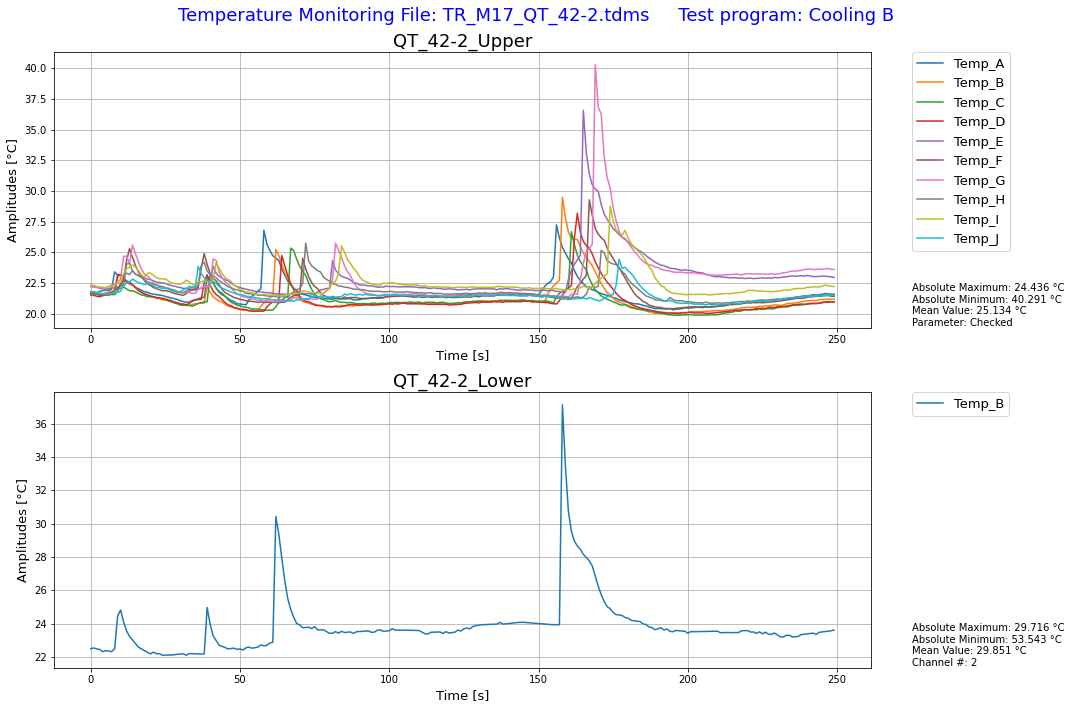

In [8]:
# Create plot and print data 
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
fig.suptitle ('Temperature Monitoring File: '+ test_file_name + '     Test program: ' + program_name, fontsize=CurrFontsize, color='blue')

ax1.set_title(group_names[1], fontsize=CurrFontsize)
PlotArea(ax1, bulk_data[1],  channels[1], False, formatted_properties[1])
ax2.set_title(group_names[0], fontsize=CurrFontsize)
PlotArea(ax2, bulk_data[0], channels[0], True, formatted_properties[0])

plt.tight_layout()
plt.show()